In [1]:
from flyingpigeon import weatherregimes as wr
from flyingpigeon import utils
from os import listdir, path ,getenv
import numpy as np

HOME = getenv('HOME')

In [2]:
from flyingpigeon.visualisation import plot_kMEAN, plot_pressuremap, concat_images
from IPython.display import Image
from numpy import ma, mean

In [3]:
p = HOME + '/.conda/envs/birdhouse/var/lib/cache/pywps/www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep.reanalysis.dailyavgs/surface'
observation = [path.join(p,f) for f in listdir(p)]
# or simply run:
# observation = wr.get_NCEP(start=1960, end=2014)

p = HOME+'/.conda/envs/birdhouse/var/lib/cache/pywps/esgf1.dkrz.de/thredds/fileServer/cmip5/cmip5/output1/MPI-M/MPI-ESM-LR/historical/day/atmos/day/r1i1p1/v20111006/psl'
model = [path.join(p,f) for f in listdir(p)]

In [4]:
len(observation)

69

In [7]:
from flyingpigeon import utils
utils.get_variable(observation[0])

u'slp'

In [ ]:
nc_obs = wr.subset(observation, bbox="-80,50,22.5,70", time_region='12,1,2')

In [6]:
nc_model = wr.subset(model, bbox="-80,50,22.5,70", time_region='12,1,2', regrid_destination=nc_obs)

/homel/nhempel/.conda/envs/birdhouse/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


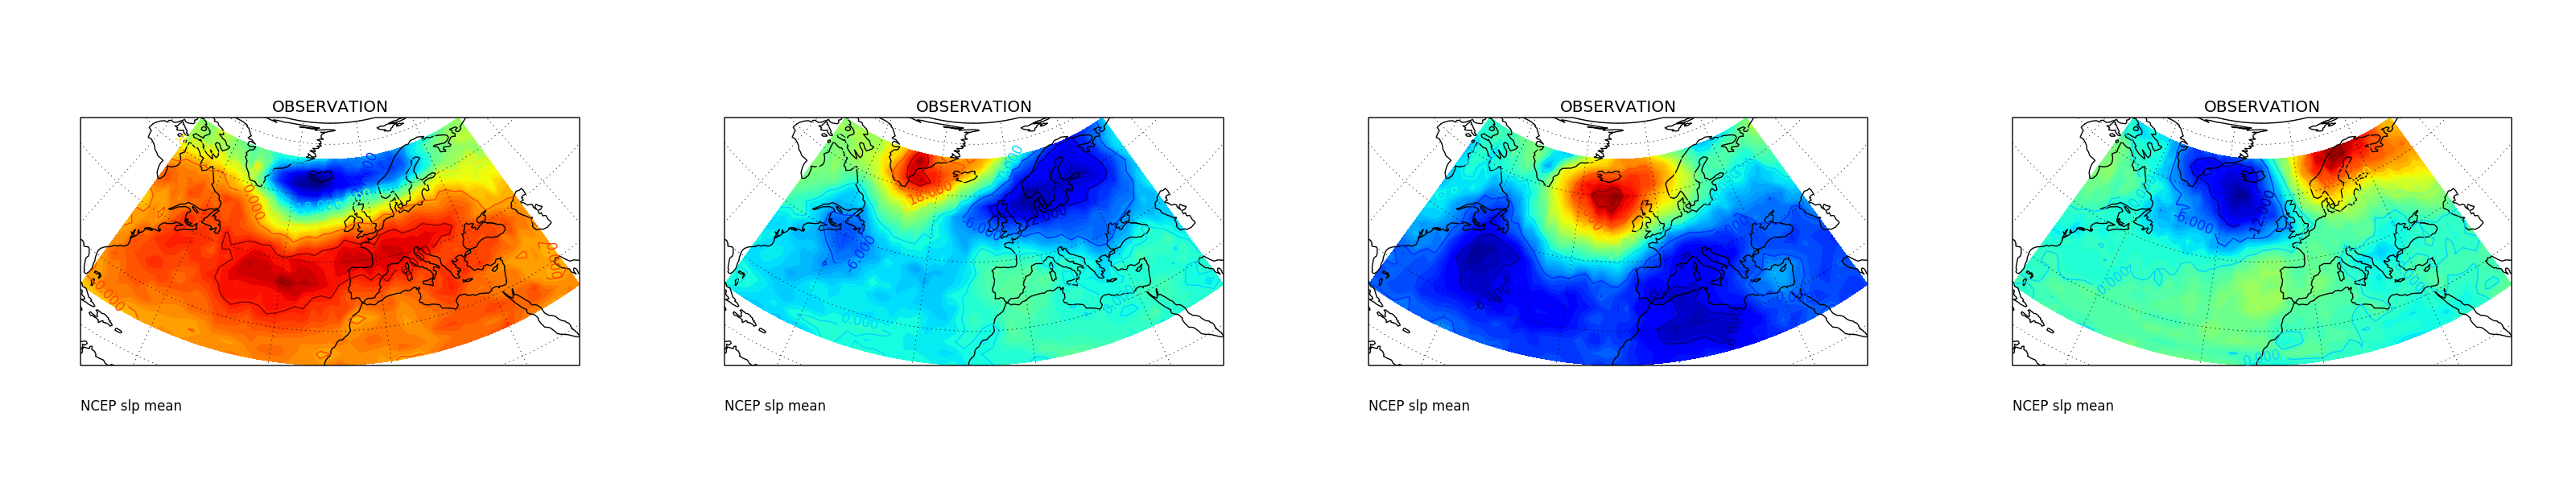

In [6]:

file = nc_obs
pca = wr.get_pca(file)
centroids, distance, regime = wr.calc_kMEAN(pca)

lats, lons = utils.get_coordinates(file)
data = utils.get_values(file)

subplots = []
obs_pattern = []
pattern_reshape = []

for i in range(4):
    d_mask = ma.masked_array(distance[:,i], mask=(regime==i))
    best_pattern = d_mask.argsort()[0:10]
    pattern = mean(data[best_pattern], axis = 0)
    obs_pattern.append(pattern)
    if i == 0 : 
        m, n  = obs_pattern[0].shape
    pattern_reshape.append(np.reshape(pattern, (n*m)))
    subplots.append(plot_pressuremap(pattern,
    facecolor = '#E0E0E0',
    lats=lats, 
    lons=lons, 
    title='OBSERVATION' , 
    sub_title='NCEP slp mean'))
#    regime_dic['NCEP']['weather regime %s' % i] = mean(data_ncep[best_pattern], axis = 0)

con_obs = concat_images(subplots, orientation='h')
Image(filename=con_obs)

In [7]:
from cartopy import config
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
from tempfile import mkstemp


def plot_pressuremap(data, lats=None, lons=None,
                    facecolor=None,  edgecolor=None,
                    title='Pressure Pattern', 
                    sub_title='plotted in birdhouse'):
    """
    plots pressure data
    :param data: 2D or 3D array of pressure data. if data == 3D a mean will be calculated
    :param lats: 1D or 2D array for latitude coordinates (geographcal map will be plotted if lats / lons are provided)
    :param lons: 1D or 2D array for longitude coordinates (geographcal map will be plotted if lats / lons are provided)
    :param title: string for title
    :param sub_title: string for sub_title
    """
    from numpy import squeeze, mean, meshgrid
    d = squeeze(data)

    if len(d.shape)==3:
        d = mean(d, axis=0)
      
    fig = plt.figure( 
  
# fig.patch.set_facecolor(facecolor)
  
    if not (lats == None or lons == None):
        if len(lats.shape) == 1: 
            lons, lats = meshgrid( lons, lats)
        central_longitude = int(mean(lons))
    
    #AlbersEqualArea(central_longitude=0.0, central_latitude=0.0, false_easting=0.0, false_northing=0.0, standard_parallels=(20.0, 50.0), globe=None)
    
        ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=central_longitude), axisbg=facecolor) #,Robinson(central_longitude=central_longitude))
        ax.gridlines() 
        ax.coastlines()
    
        cf = plt.contourf(lons, lats, d, 60, transform=ccrs.PlateCarree(), cmap='jet', interpolation=None) #'nearest'
        co = plt.contour(lons, lats, d, transform=ccrs.PlateCarree(), lw=2, color='black')
    else:
        cf = plt.contourf(d)
        co = plt.contour(d, lw=2, c='black')
    
  # plt.colorbar(cf)
    plt.clabel(co, inline=1) # fontsize=10
    plt.title(title)
    plt.annotate(sub_title, (0,0), (0, -30), xycoords='axes fraction',
               textcoords='offset points', va='top')

    ip, image = mkstemp(dir='.',suffix='.png')
    plt.savefig(image)
    plt.close()

    return image

plot = plot_pressuremap(pattern,
    facecolor = '#E0E0E0',
    lats=lats, 
    lons=lons, 
    title='OBSERVATION' , 
    sub_title='NCEP slp mean')
Image(filename=plot)

SyntaxError: invalid syntax (<ipython-input-7-cc39e3eaf533>, line 29)

In [72]:
plt.figure?

In [48]:
plt.axes?

/homel/nhempel/.conda/envs/birdhouse/lib/python2.7/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


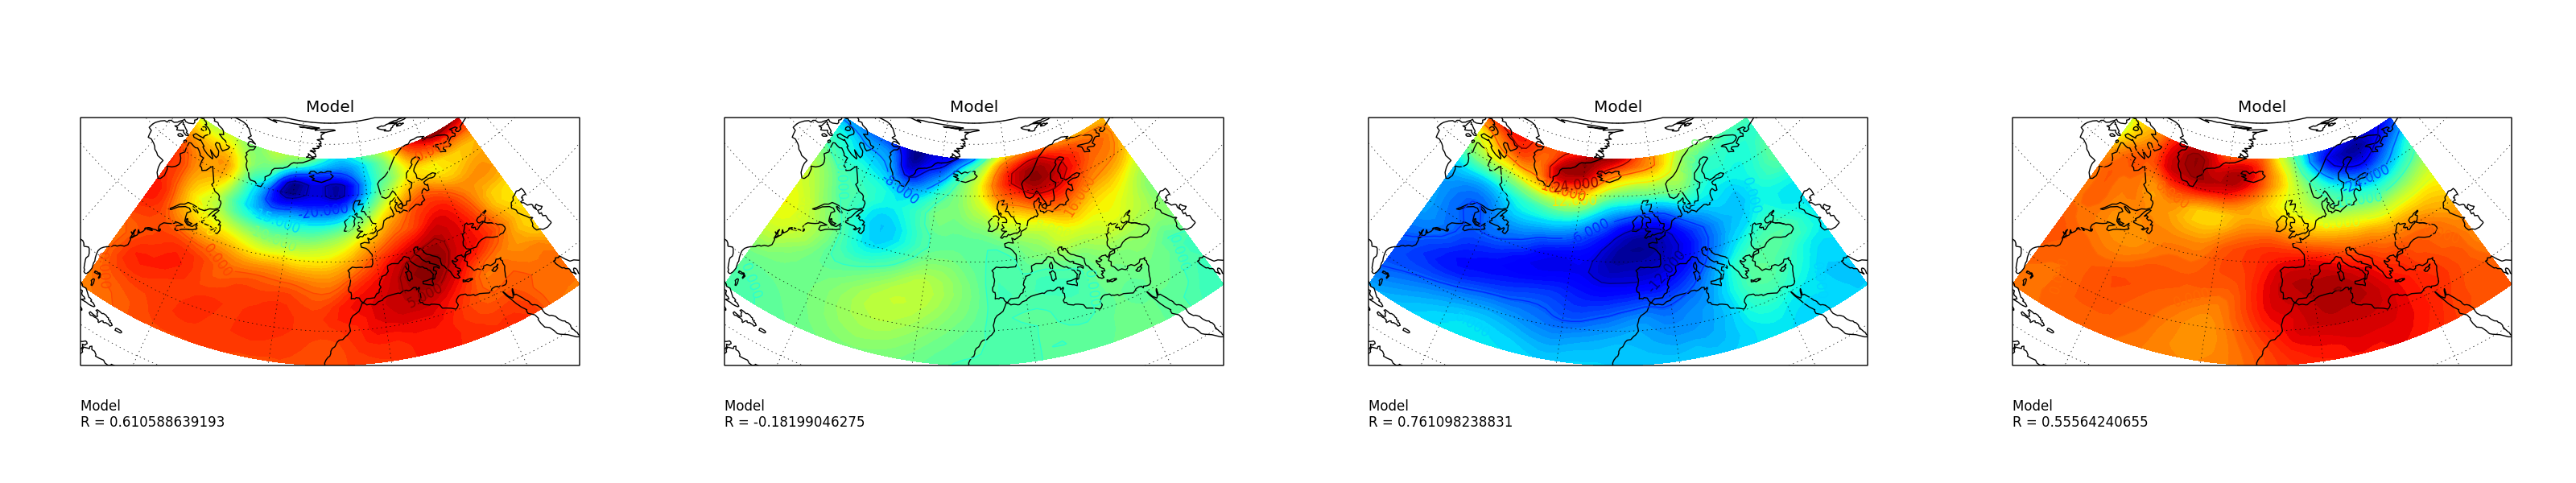

In [11]:
file = nc_model
pca = wr.get_pca(file)
centroids, distance, regime = wr.calc_kMEAN(pca)

lats, lons = utils.get_coordinates(file)
data = utils.get_values(file)

from scipy import stats

subplots = []

stat_vals = np.ones([4, 5]) * -1 
r_vals = np.ones([4]) * -1
order = np.ones([4]) * -1
model_pattern = []

for i in [0,1,2,3]:
    # get first 10 clostest patterns to the centroide
    d_mask = ma.masked_array(distance[:,i], mask=(regime==i))
    best_pattern = d_mask.argsort()[0:10]
    
    pattern = []
    pattern = mean(data[best_pattern], axis = 0)
    model_pattern.append(pattern)
    x = np.reshape(pattern, (n*m))
    pattern_reshape.append(np.reshape(pattern, (n*m)))
    
    #### compare with observation    
    for j in [0,1,2,3]:
        r_value = None
        y = np.reshape(obs_pattern[j], (n*m))
        alpha, beta, r_value, p_value, std_err = stats.linregress(x, y)
        
        # print 'model',i , 'obs', j
        if r_vals[j] <= r_value: #r_value >= stat_vals[j][2]:
            r_vals[j] = r_value
            #stat_vals[i,:] = [alpha, beta, r_value, p_value, std_err]
            order[j] = i
        
    subplots.append(plot_pressuremap(pattern,
    lats=lats, 
    lons=lons, 
    title='Model' , 
    sub_title='Model \nR = %s \n' % r_vals[i] ))

subplots_ordered = [subplots[int(i)] for i in order]
con = concat_images(subplots_ordered, orientation='h')
Image(filename=con)

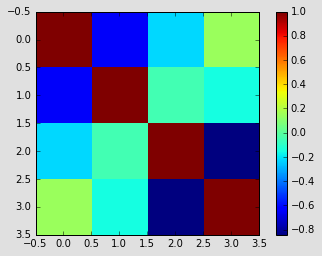

In [53]:
import matplotlib.pyplot as plt
# %matplotlib inline

fig = plt.figure(num=None, figsize=None, dpi=None, facecolor='#E0E0E0')

#fig.set_edgecolor('r')
plt.colorbar()
ax = plt.gca()
ax.patch.set_facecolor('black') # set_axis_bgcolor('red')


In [54]:
ax.patch.set_fc

<bound method Rectangle.set_fc of <matplotlib.patches.Rectangle object at 0x7fb091aeff10>>

In [57]:
plt.show()